# 2.1 임의표본추출과 표본분포: 편향에 대해서

모집단에 대한 대표성이 있는 표본을 기준으로 검정이 이루어져야 한다. 물론 모집단도 선택적이어서는 안된다. 이의 토대가 되는 방법들을 배운다.

검정을 할때는 먼저 아래와 같은 것들이 이루어진다.
- 검정의 목표 및 관심 통계량 등 설정
- 모집단의 정의
- 표본집단의 정의
- 비교집단의 정의
- 검정

일반적으로 표본집단의 통계량이 유의미한지를 보게 된다. 이를 위해 전통적인 통계는 검정통계량의 근사 가능한 분포를 통해 검정을 한다. 이는 두가지 문제가 있다.

1. 검정할 수 있는 통계량이 한정적이다.
2. 복잡한데 제한적인 결과를 보게 된다.


데이터 과학은 설정된 표본 집단과 비교 집단을 모집단에서 랜덤으로 생성해내서 반복을 통해 분포를 추론한다. 중요한건 랜덤이다. 임의표본추출 방식으로 편향을 없애야 의미 있는 비교가 된다.이러한 것들을 주로 배우고 전통적인 통계를 곁들인다.

코드 정리 전 한가지 더 정리할 것은 과정이 해결해줄 수 없는 것들이 있다는 점이다. 순열 검정을 완벽한 방법으로 했다 하더라도 내가 모집단,표본집단,비교집단 등의 정의가 잘못되면(또는 검정의 목표와 무관하면) 안된다.

또한 크기는 더 좋은 결과를 낼 수 있다면 큰게 좋다. 무조건 클 필요는 없다.

In [2]:
%matplotlib inline

from pathlib import Path
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.utils import resample

import seaborn as sns
import matplotlib.pylab as plt



In [3]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'practical-statistics-for-data-scientists/practical-statistics-for-data-scientists/data'

In [4]:
LOANS_INCOME_CSV = DATA / 'loans_income.csv'
SP500_DATA_CSV = DATA / 'sp500_data.csv.gz'

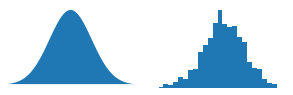

In [5]:
np.random.seed(seed=1)
x = np.linspace(-3, 3, 300)
xsample = stats.norm.rvs(size=1000)

fig, axes = plt.subplots(ncols=2, figsize=(5, 1.5))

ax = axes[0]
ax.fill(x, stats.norm.pdf(x))
ax.set_axis_off()
ax.set_xlim(-3, 3)

ax = axes[1]
ax.hist(xsample, bins=30)
ax.set_axis_off()
ax.set_xlim(-3, 3)
ax.set_position
# plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

plt.show()

## 샘플링 기본

In [6]:
loans_income = pd.read_csv(LOANS_INCOME_CSV, squeeze=True)
print(loans_income.shape)
loans_income.head()

(50000,)


0     67000
1     52000
2    100000
3     78762
4     37041
Name: x, dtype: int64

In [7]:
sample_data = pd.DataFrame({
    'income': loans_income.sample(1000),
    'type': 'Data',
})

sample_mean_05 = pd.DataFrame({
    'income': [loans_income.sample(5).mean() for _ in range(1000)],
    'type': 'Mean of 5',
})

sample_mean_20 = pd.DataFrame({
    'income': [loans_income.sample(20).mean() for _ in range(1000)],
    'type': 'Mean of 20',
})

results = pd.concat([sample_data, sample_mean_05, sample_mean_20])
print(results.head())

         income  type
40292   63000.0  Data
38959   92000.0  Data
17361  134000.0  Data
33996   52000.0  Data
26491   43000.0  Data


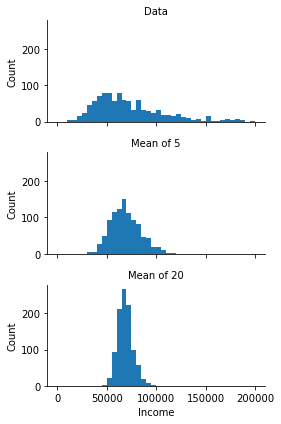

In [8]:
g = sns.FacetGrid(results, col='type', col_wrap=1, 
                  height=2, aspect=2)
g.map(plt.hist, 'income', range=[0, 200000], bins=40)
g.set_axis_labels('Income', 'Count')
g.set_titles('{col_name}')


plt.tight_layout()
plt.show()



 표본분포의 변동성은 표준오차로 확인이 가능하다. 표준오차란 개별 데이터의 변동성(표준편차)와는 다르다. 표준오차는 표본 측정지표의 변동성이다. 예를 들어 평균값을 어떤 표본에서 구할 때 이 자체는 하나의 값으로 측정되며 여기는 오차가 있을수 있다. 이걸 모아 놓은게 표준오차다.
 
 이 표준오차는 표본크기가 크면 줄어든다. 위 그림처럼 말이다. 일반적으로 표준오차를 2배줄이려면 크기를 4배 늘려야한다. 그러나 부트스트랩 방식을 사용하면 샘플의 수집없이(표본크기를 안키워도) 표준오차 추정이 정밀하게 가능하다. 이는 꼭 표준오차가 아니어도 다른 통계량도 적용된다.


In [9]:
results = []
for nrepeat in range(1000):
    sample = resample(loans_income)
    results.append(sample.median())
results = pd.Series(results)
print('Bootstrap Statistics:')
print(f'original: {loans_income.median()}')
print(f'bias: {results.mean() - loans_income.median()}')
print(f'std. error: {results.std()}')

Bootstrap Statistics:
original: 62000.0
bias: -82.09799999999814
std. error: 228.73933106830748


## 부트스트랩 효용 비교

복원하여 추출하는 과정이 실제로 표준오차를 측정할까

In [10]:
# 교재에선 중간값이었지만 위 결과와 비교를 위해 평균으로 부트스트랩. 

# 20개의 샘플로 부트스트랩
test_set = loans_income.sample(20)

results = []
for nrepeat in range(1000):
    sample = resample(test_set)
    results.append(sample.mean())
results_li = results
results = pd.Series(results)

#전체 데이터로 부트

results = []
for nrepeat in range(1000):
    sample = resample(loans_income)
    results.append(sample.mean())
total_li = results
total = pd.Series(results)



In [11]:
boot = pd.DataFrame({
    'income': results_li,
    'type': 'Boot of 20 data',
})

boot_total = pd.DataFrame({
    'income': total_li,
    'type': 'Boot of Total',
})

grid = pd.concat([sample_mean_20,boot,boot_total])

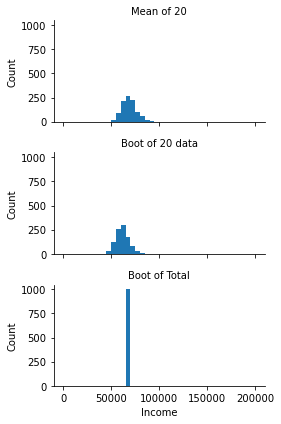

In [12]:
g = sns.FacetGrid(grid, col='type', col_wrap=1, 
                  height=2, aspect=2)
g.map(plt.hist, 'income', range=[0, 200000], bins=40)
g.set_axis_labels('Income', 'Count')
g.set_titles('{col_name}')


plt.tight_layout()
plt.show()

20개 샘플의 표준오차를 확인하기위해서 꼭 다른 데이터가 필요하지 않다. 20개 데이터를 부트스트랩하더라도 해당 샘플의 표준오차를 확인할 수가 있다. 정확도를 올리는 방법과는 무관하다. 분포를 알려줄 뿐 오차가 줄어드는건 당연히 아니라는 것.

표준오차가 아니더라도 부트스트랩으로 얻은 분포에서의 지표는 모두 사용 가능하다. 과정을 유념하자

1. 복원 추출 후 통계량 기록을 n번 반복
2. 해당 결과로 분포, 표준오차 등 보기


## Confidence Intervals(신뢰구간)

부트스트랩으로 신뢰구간을 구할 수 있다. 원래는(전통 통계학은) 내가 평균의 신뢰구간을 얻고자 한다면 모평균 정규분포를 따르고 표본평균이 t분포를 따른다는 이론하에 t분포의 신뢰구간으로 통계량의 신뢰구간을 설정한다. 하지만 부트스트랩은 분포를 구현해서 계산한다. 더 직관적이고 변형이 가능하다. 

애초에 적은데이터로 분포를 구해내는게 놀랍긴하다. 그래서 자주 헷갈리니 조심하자

68760.51844
55734.1


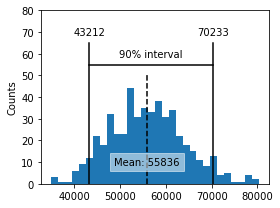

In [13]:
print(loans_income.mean())
np.random.seed(seed=3)  #난수가 같으면 같은값이 나온다.
# create a sample of 20 loan income data
sample20 = resample(loans_income, n_samples=20, replace=False)
print(sample20.mean())

#부트스트랩 표본평균의 분포
results = []
for nrepeat in range(500):
    sample = resample(sample20)
    results.append(sample.mean())
results = pd.Series(results)

#신뢰구간 설정
confidence_interval = list(results.quantile([0.05, 0.95]))

#분포 그림
ax = results.plot.hist(bins=30, figsize=(4, 3))

#신뢰구간 표시
ax.plot(confidence_interval, [55, 55], color='black') #수평선 표시
for x in confidence_interval:
    ax.plot([x, x], [0, 65], color='black') #수직선표시
    ax.text(x, 70, f'{x:.0f}', 
            horizontalalignment='center', verticalalignment='center') #숫자표시
ax.text(sum(confidence_interval) / 2, 60, '90% interval',
        horizontalalignment='center', verticalalignment='center') #중간글자표시

#평균 표시
meanIncome = results.mean()
ax.plot([meanIncome, meanIncome], [0, 50], color='black', linestyle='--')
ax.text(meanIncome, 10, f'Mean: {meanIncome:.0f}',
        bbox=dict(facecolor='white', edgecolor='white', alpha=0.5),
        horizontalalignment='center', verticalalignment='center')
ax.set_ylim(0, 80)
ax.set_ylabel('Counts')

plt.tight_layout()
plt.show()

In [14]:
confidence_interval

[43212.45, 70233.43999999999]

## Normal Distribution(정규 분포)

Standard Normal and QQ-Plots
The package scipy has the function (scipy.stats.probplot) to create QQ-plots. The argument dist specifies the distribution, which is set by default to the normal distribution.
qq 그림 - 걍 정규분포인지 확인하기 쉬운것.45도 선 기준으로 클수록  위로, 작을수록 아래로 가면 긴꼬리 분포다.(tail risk)

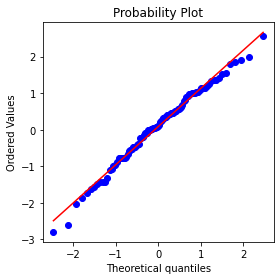

In [15]:
fig, ax = plt.subplots(figsize=(4, 4))

norm_sample = stats.norm.rvs(size=100)
stats.probplot(norm_sample, plot=ax) #qq플랏. 정규화도 알아서 해줌.

plt.tight_layout()
plt.show()

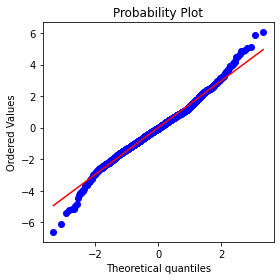

In [16]:
#주가는 역시 롱테일
sp500_px = pd.read_csv(SP500_DATA_CSV)

nflx = sp500_px.NFLX
nflx = np.diff(np.log(nflx[nflx>0])) # 양의 수익률. 로그화 후 빼기 (로그로 선형성,정규성 확보하려 한듯 divide 0 에러 때문에 양의 값만)

fig, ax = plt.subplots(figsize=(4, 4))
stats.probplot(nflx, plot=ax)

plt.tight_layout()
plt.show()

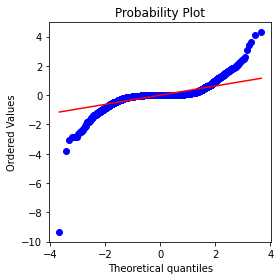

In [17]:
fig, ax = plt.subplots(figsize=(4, 4))


stats.probplot(sp500_px.NFLX, plot=ax)

plt.tight_layout()
plt.show()

# Binomial Distribution(이항 분포)

이항분포는 n번의 베르누이 분포

성공횟수,시행횟수,성공확률 3개만 알면 분포를 그릴 수 있음.

물론 성공횟수 부트스트랩해도 같은 비슷한 결과 나올 것

In [18]:
print(stats.binom.pmf(2, n=5, p=0.1)) #확률질량함수 (연속형일땐 확률밀도함수)

0.0729


In [19]:
print(stats.binom.cdf(2, n=5, p=0.1)) #누적확률질량함수 두번 이하 누적 값

0.99144


# Poisson and Related Distribution

카이제곱분포: 카이제곱통계량은 검정결과가 독립성에 대한 귀무 기댓값에서 벗어난 정도를 측정하는 통계량이다. 
수식은 ((관측값 - 기댓값) /(기댓값제곱근))제곱 의 sum. 즉 크면 독립적임을 의미하는건가. 
특정분포 적합성 검정일 땐 낮을수록 해당분포에 더 적합하다는 의미.
다중 검정에도 사용.
범주에 속하는 주제 또는 항목의 수와 관련 있다.
검정에서 좀더 자세히 보자.

F분포: 카이제곱분포와 달리 연속된 관측값을 처리한다.
분산분석(anova)에서 다룬다. 분산분석 간단히 여러 그룹 평균 간 차이가 유의미한지

## Poisson Distributions

### 용어 정리
람다: 단위 시간이나 단위 면적당 사건이 발생하는 비율
푸아송분포: 표집된 단위 시간 혹은 단위 공간에서 발생한 사건의 도수분포.
지수분포: 한 사건에서 그다음 사건까지의 시간이나 거리에 대한 도수분포.
베이불분포: 사건 발생률이 시간에 따라 변화하는 지수분포의 일반화된 버전.

람다를 먼저 파악할 필요가 있다. 람다는 이항분포의 평균과 비슷하다. 단위는 내가 정하는 것. 1분당 2회 시그널이면 람다 2. 총 시간의 문제가 아니다 언제나 시간 공간이 걍 주어지면 되는 것..? 각 사건의 독립성 조건 필요.

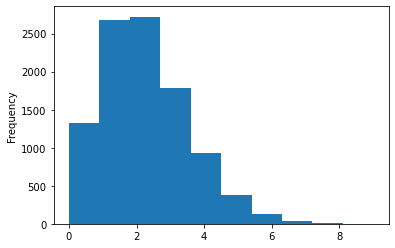

In [20]:
sample = stats.poisson.rvs(2, size=10000)

pd.Series(sample).plot.hist()
plt.show()
#람다 2인 푸아송 분포

2.0


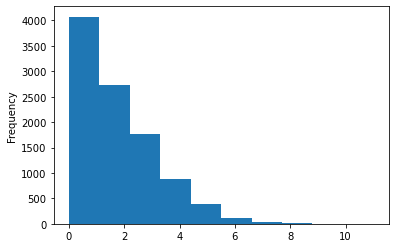

In [21]:
#확률이 0.0002이고 시행회수 10000인 이항분포를 보자
n=10000
p=0.0002
binom_sample = stats.binom.rvs(n=10000, p=0.0002,size = 10000)
_lambda = n*p

print(_lambda)
pd.Series(binom_sample).plot.hist()
plt.show()

#푸아송은 이항분포다. 작은 단위의 시간을 다루기 위해 푸아송 개념이 생긴건가 싶다.

## Exponential Distribution

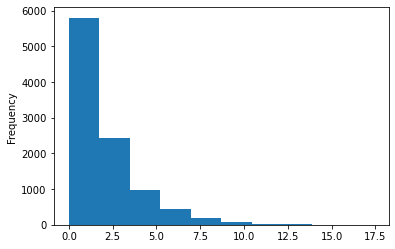

In [23]:
sample = stats.expon.rvs(scale=2, size=10000)

pd.Series(sample).plot.hist()
plt.show()

##  Weibull Distribution

포아송이나 지수분포는 람다가 일정해야하지만 베이불은 람다가 변한다. 정확히는 계수(베타)만큼 증가하거나 감소한다.

모수는 세가지다.

베타: 형상 파라미터. 승수 역할을 한다.

에타: 특성 수명. 

이 모수를 추정하여 적합한 베이불분포를 추정하고 데이터를 모델링 해야한다.

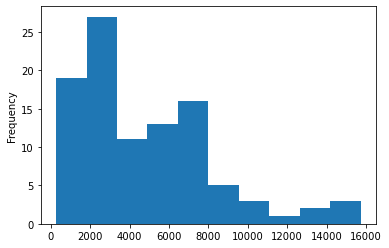

In [25]:
sample = stats.weibull_min.rvs(1.5, scale=5000, size=100)

pd.Series(sample).plot.hist()
plt.show()